In [1]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, StackingClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

from sklearn.metrics import (
    accuracy_score, balanced_accuracy_score,
    precision_score, recall_score, f1_score,
    roc_auc_score, confusion_matrix
)

from imblearn.over_sampling import SMOTE


In [2]:
data = pd.read_csv("C:/Users/Lenovo T480/Downloads/chagasds/signals_features.csv")


In [3]:
#Preprocessing
print(data.shape[0])
df_clean = data.dropna()
df_clean = df_clean.drop(columns =['exam_id'])
print(df_clean.shape[0])
df_clean.head()

13092
12733


,P_wave_duration_mean,P_wave_duration_std,P_wave_duration_min,P_wave_duration_max,PR_interval_mean,PR_interval_std,PR_interval_min,PR_interval_max,PR_segment_mean,PR_segment_std,...,HRV_Prc80NN,HRV_pNN50,HRV_pNN20,HRV_MinNN,HRV_MaxNN,HRV_HTI,HRV_TINN,age,is_male,chagas
0,36.250000,10.856203,17.5,47.5,137.812500,39.830836,110.0,222.5,101.562500,40.903578,...,1110.0,55.555556,66.666667,865.0,1135.0,4.500000,250.0000,55,False,False
1,44.285714,4.498677,37.5,52.5,87.857143,0.944911,87.5,90.0,43.571429,4.531635,...,735.0,0.000000,12.500000,710.0,740.0,2.666667,0.0000,38,False,False
2,66.590909,5.156637,60.0,75.0,86.818182,8.069302,72.5,95.0,20.227273,10.808246,...,781.0,0.000000,8.333333,735.0,792.5,6.000000,23.4375,48,False,False
3,23.333333,7.180703,15.0,40.0,146.944444,16.619726,127.5,182.5,123.611111,17.682579,...,787.0,25.000000,66.666667,640.0,822.5,4.000000,148.4375,33,False,False
4,65.000000,25.248762,35.0,92.5,128.125000,68.446299,82.5,230.0,63.125000,62.861455,...,800.0,0.000000,16.666667,737.5,805.0,3.000000,46.8750,81,False,False


In [4]:
print(df_clean.columns)

Index(['P_wave_duration_mean', 'P_wave_duration_std', 'P_wave_duration_min',
       'P_wave_duration_max', 'PR_interval_mean', 'PR_interval_std',
       'PR_interval_min', 'PR_interval_max', 'PR_segment_mean',
       'PR_segment_std', 'PR_segment_min', 'PR_segment_max',
       'QRS_duration_mean', 'QRS_duration_std', 'QRS_duration_min',
       'QRS_duration_max', 'QT_interval_mean', 'QT_interval_std',
       'QT_interval_min', 'QT_interval_max', 'ST_segment_mean',
       'ST_segment_std', 'ST_segment_min', 'ST_segment_max', 'ST_slope_mean',
       'ST_slope_std', 'ST_slope_min', 'ST_slope_max', 'HRV_MeanNN',
       'HRV_SDNN', 'HRV_RMSSD', 'HRV_SDSD', 'HRV_CVNN', 'HRV_CVSD',
       'HRV_MedianNN', 'HRV_MadNN', 'HRV_MCVNN', 'HRV_IQRNN', 'HRV_SDRMSSD',
       'HRV_Prc20NN', 'HRV_Prc80NN', 'HRV_pNN50', 'HRV_pNN20', 'HRV_MinNN',
       'HRV_MaxNN', 'HRV_HTI', 'HRV_TINN', 'age', 'is_male', 'chagas'],
      dtype='object')


In [8]:
from sklearn.feature_selection import mutual_info_classif
target = 'chagas'
X = df_clean.drop(columns=[target])
y = df_clean[target]

#info gain step!
mi_scores = mutual_info_classif(X, y, random_state=42)

mi_df = pd.DataFrame({
    'feature': X.columns,
    'information_gain': mi_scores
}).sort_values(by='information_gain', ascending=False)

print("Top 15 features based on Information Gain:")
print(mi_df.head(15))

Top 15 features based on Information Gain:
                 feature  information_gain
8        PR_segment_mean          0.057764
47                   age          0.056084
23        ST_segment_max          0.050848
20       ST_segment_mean          0.048363
0   P_wave_duration_mean          0.047366
16      QT_interval_mean          0.045430
4       PR_interval_mean          0.045206
12     QRS_duration_mean          0.045178
29              HRV_SDNN          0.044093
32              HRV_CVNN          0.043103
1    P_wave_duration_std          0.041422
17       QT_interval_std          0.038256
31              HRV_SDSD          0.038142
9         PR_segment_std          0.037983
45               HRV_HTI          0.036771


In [24]:
## XGBOOST


In [9]:

numeric_cols = df_clean.drop(columns=[target]).select_dtypes(include="number").columns
q_bounds = df_clean[numeric_cols].quantile([0.025, 0.975])

mask = pd.Series(True, index=df_clean.index)
for col in numeric_cols:
    lo = q_bounds.loc[0.025, col]
    hi = q_bounds.loc[0.975, col]
    mask &= df_clean[col].between(lo, hi, inclusive="both")

# 3) Apply the mask (leave the target untouched) and reset the index
df_trimmed = df_clean[mask].reset_index(drop=True)

print(f"Original rows: {df_clean.shape[0]}")
print(f"Rows after dropping top/bottom 2.5%: {df_trimmed.shape[0]}")


Original rows: 12733
Rows after dropping top/bottom 2.5%: 5829


Accuracy:  0.72
Recall:    0.72
Precision: 0.71
F1 Score:  0.72
AUC:       0.78


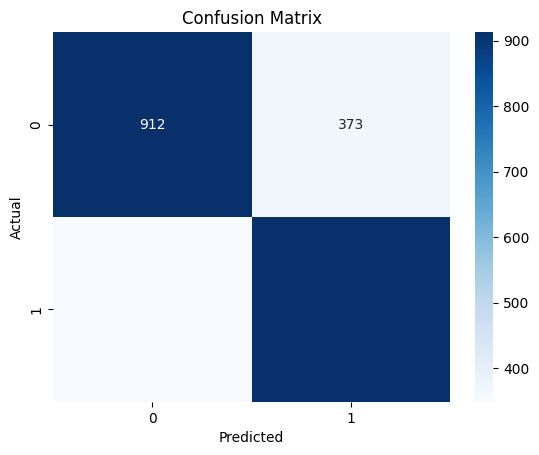

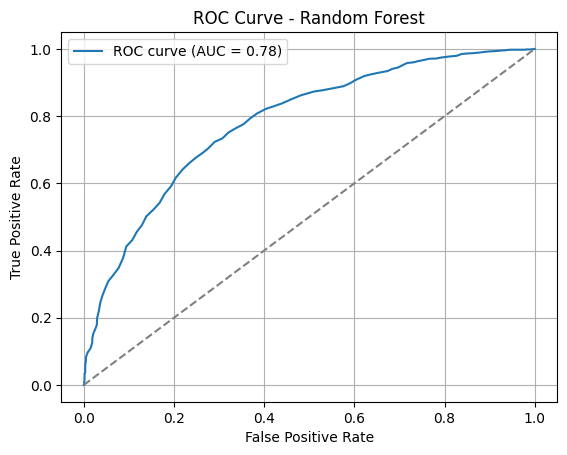

In [12]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score, recall_score, precision_score, f1_score,
    roc_auc_score, roc_curve, confusion_matrix
)
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split

# Assuming you already have X and y defined
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y  # stratify to preserve class balance
)

# Train a Random Forest model
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Predict on test set
y_pred = model.predict(X_test)
y_proba = model.predict_proba(X_test)[:, 1]

# Evaluate performance
accuracy = accuracy_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
auc = roc_auc_score(y_test, y_proba)

print(f"Accuracy:  {accuracy:.2f}")
print(f"Recall:    {recall:.2f}")
print(f"Precision: {precision:.2f}")
print(f"F1 Score:  {f1:.2f}")
print(f"AUC:       {auc:.2f}")

# --- Plot Confusion Matrix ---
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# --- Plot ROC Curve ---
fpr, tpr, _ = roc_curve(y_test, y_proba)
plt.figure()
plt.plot(fpr, tpr, label=f"ROC curve (AUC = {auc:.2f})")
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - Random Forest")
plt.legend()
plt.grid(True)
plt.show()
